In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
!pip install keras-tuner
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """


In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
(trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 2s 0us/step


In [4]:
# convert from integers to floats
#train_norm = trainX.astype('float32')
#test_norm = testX.astype('float32')
# normalize to range 0-1
trainX = trainX / 255.0
testX = testX / 255.0

In [5]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [7]:
trainX.shape

(50000, 32, 32, 3)

In [8]:
testX.shape

(10000, 32, 32, 3)

In [ ]:
dir(trainX)

In [6]:
class_names=["airplane","automobile","bird","cad","deer","dog","frog","horse","ship","truck"]


In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(trainX[i])
  plt.xlabel(class_names[trainY[i][0]])
plt.show()  

In [8]:
# define cnn model
def build_model(hp):
	model = Sequential()
	hp_filters = hp.Int('filters', min_value = 32, max_value = 64, step = 32)
	model.add(Conv2D(filters=hp_filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	# compile model
	#opt = SGD(lr=0.001, momentum=0.9)
	hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3])
	opt = Adam(learning_rate=hp_learning_rate)#, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [9]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='my_dir1') #change the directory name here  when rerunning the cell else it gives "Oracle exit error" 

tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [10]:
tuner.search(trainX, trainY,
             epochs=5,
             validation_data=(testX, testY))

Trial 4 Complete [00h 01m 24s]
val_accuracy: 0.7921000123023987

Best val_accuracy So Far: 0.7921000123023987
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in my_dir1/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 64
learning_rate: 0.001
Score: 0.7921000123023987
Trial summary
Hyperparameters:
filters: 32
learning_rate: 0.001
Score: 0.7904999852180481
Trial summary
Hyperparameters:
filters: 64
learning_rate: 0.01
Score: 0.7731000185012817
Trial summary
Hyperparameters:
filters: 32
learning_rate: 0.01
Score: 0.7411999702453613


In [12]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

# probing function tuner.get_best_hyperparameters(1) #skip this if details are not required
print(type(tuner.get_best_hyperparameters(1))) #list
for data in tuner.get_best_hyperparameters(1):
  print(data.values)


{'filters': 64, 'learning_rate': 0.001}
<class 'list'>
{'filters': 64, 'learning_rate': 0.001}


In [13]:
n_best_models = tuner.get_best_models(num_models=2)
print(n_best_models[0].summary())                    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [15]:
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(trainX, trainY,
                      epochs=5,
                      validation_data=(testX, testY))

Epoch 1/5
1563/1563 [==============================] - 15s 9ms/step - loss: 1.5661 - accuracy: 0.4552 - val_loss: 1.1406 - val_accuracy: 0.5946
Epoch 2/5
1563/1563 [==============================] - 13s 9ms/step - loss: 1.0486 - accuracy: 0.6302 - val_loss: 0.9050 - val_accuracy: 0.6773
Epoch 3/5
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8802 - accuracy: 0.6947 - val_loss: 0.7450 - val_accuracy: 0.7331
Epoch 4/5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7841 - accuracy: 0.7300 - val_loss: 0.6654 - val_accuracy: 0.7712
Epoch 5/5
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7174 - accuracy: 0.7539 - val_loss: 0.7726 - val_accuracy: 0.7371


In [16]:
# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 73.710


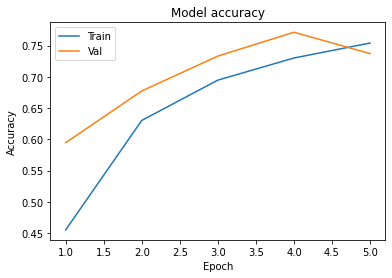

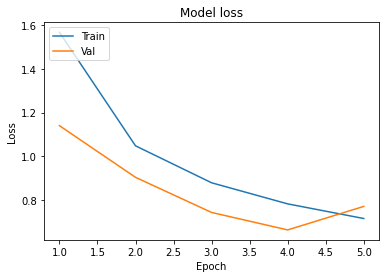

In [17]:
# Plot training & validation accuracy values
epoch_range = range(1, 6) #6 here is the number of epochs of final training
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

References:

https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739

https://scortex.io/batch-norm-folding-an-easy-way-to-improve-your-network-speed/